## Setup

In [1]:
!pip -q install gym gym[atari] pyvirtualdisplay piglet
!apt-get -qq update
!apt-get -qq install python-opengl xvfb -y

In [2]:
import gym
from gym import logger as gymlogger
gymlogger.set_level(40)
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import io
import base64
from PIL import Image
from collections import namedtuple

import glob
import os
from gym.wrappers import Monitor
from itertools import count
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(
            HTML(
                data='''
                    <video alt="test" controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>
                '''.format(encoded.decode('ascii'))
            )
        )
    else: 
        print("Could not find video")

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

resize = T.Compose([T.ToPILImage(),
                    T.Resize(80, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen(env):
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)

def make_video(policy, env, device='cpu'):
    env = wrap_env(env)
    env.reset()

    last_screen = get_screen(env).to(device)
    current_screen = get_screen(env).to(device)
    state = current_screen - last_screen

    while True:
        env.render()

        action = select_action(policy, state)
        _, _, done, _ = env.step(action.item())

        last_screen = current_screen
        current_screen = get_screen(env).to(device)
        next_state = current_screen - last_screen
        state = next_state

        if done:
            break
    env.close()

## Classes & Functions

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class ConvDQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(ConvDQN, self).__init__()

        self.n_outputs = outputs

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [6]:
def select_action(policy, state):
    with torch.no_grad():
        _, idx = policy(state).max(1)
        return idx.view(1, 1)

def select_action_eps(policy, state, epsilon=0.9, device='cpu'):
    if random.random() < epsilon:
        return select_action(policy, state)
    else:
        return torch.tensor([[random.randrange(policy.n_outputs)]],
                            device=device,
                            dtype=torch.long)

In [7]:
def optimize_model(policy, target, memory, loss_fn=F.smooth_l1_loss, batch_size=32, gamma=0.9):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device,
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    state_action_values = policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1})
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [8]:
def conv_train(env,
               policy,
               target,
               optimizer,
               memory,
               num_episodes=50,
               target_update=10,
               device='cpu'):

    episodes = []

    for i_episode in range(num_episodes):
        
        env.reset()

        last_screen = get_screen(env).to(device)
        current_screen = get_screen(env).to(device)
        state = current_screen - last_screen

        for t in count():

            action = select_action_eps(policy, state, device=device)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            last_screen = current_screen
            current_screen = get_screen(env).to(device)
            next_state = (current_screen - last_screen
                          if not done
                          else None)
            
            memory.push(state, action, next_state, reward)
            
            if len(memory) >= memory.capacity:
                optimize_model(policy, target, memory)

            if done:
                episode = {
                    'duration': t+1,
                }
                episodes.append(episode)
                break
            else:
                state = next_state
                
        if i_episode % target_update == 0:
            target.load_state_dict(policy.state_dict())

    return episodes

In [9]:
def conv_train(env,
                policy, target,
                optimizer, memory,
                reward_fn=(lambda env, obs: 1),
                loss_fn=F.smooth_l1_loss,
                num_episodes=100,
                max_episode_len=10000,
                target_update=10,
                print_every=10,
                device='cpu'):

    episodes = []
    i = 0

    while True:

        episode_losses = []
        
        obs = env.reset()
        last_screen = get_screen(env).to(device)
        current_screen = get_screen(env).to(device)
        state = current_screen - last_screen
        
        for t in count():
            
            env.render()

            action = select_action_eps(policy, state, epsilon=0.5, device=device)
            obs, reward, done, _ = env.step(action.item())

            reward = reward_fn(env, obs)
            reward = torch.tensor([reward], device=device)
            
            last_screen = current_screen
            current_screen = get_screen(env).to(device)
            next_state = (current_screen - last_screen
                          if not done
                          else None)
            
            memory.push(state, action, next_state, reward)

            # once memory is full, start learning
            if len(memory) == memory.capacity:
                
                loss = optimize_model(policy, target, memory, loss_fn=loss_fn)
                episode_losses.append(loss)

                if done or t+1 == max_episode_len:
                    episode = {
                        'i': i+1,
                        'duration': t+1,
                        'avg_loss': np.mean(episode_losses)
                    }
                    episodes.append(episode)
                    i += 1
                    break
            
            if done or t+1 == max_episode_len:
                break
            state = next_state

        if (i + 1) % print_every == 0:
            print(i+1)
                
        if (i + 1) % target_update == 0:
            target.load_state_dict(policy.state_dict())

        if (i + 1) == num_episodes:
            break

    return episodes

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
def plot_durations(durations, avg_window=25):
    avgs = moving_average(durations, avg_window)
    plt.plot(durations)
    plt.plot(avgs)
    plt.show()   

def plot_losses(losses):
    plt.plot(losses)
    plt.show()

## Train

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
env = gym.make('CartPole-v0').unwrapped
env.reset();

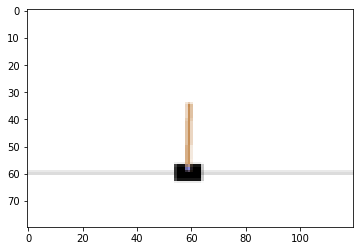

In [22]:
init_screen = get_screen(env).to(device)
_, _, screen_height, screen_width = init_screen.shape

plt.figure()
plt.imshow(init_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.show()

In [23]:
n_actions = env.action_space.n

conv_policy_net = ConvDQN(screen_height, screen_width, n_actions).to(device)
conv_target_net = ConvDQN(screen_height, screen_width, n_actions).to(device)

conv_target_net.load_state_dict(conv_policy_net.state_dict())
conv_target_net.eval()


optimizer = optim.RMSprop(conv_policy_net.parameters())
memory = ReplayMemory(2000)

In [31]:
episodes = conv_train(env,
                      conv_policy_net,
                      conv_target_net,
                      optimizer,
                      memory,
                      loss_fn=F.smooth_l1_loss,
                      num_episodes=1000,
                      max_episode_len=200,
                      target_update=50,
                      print_every=50,
                      device=device)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


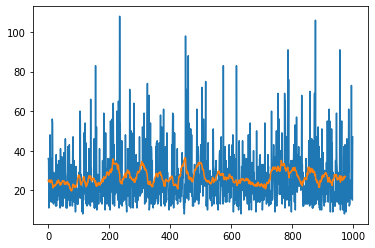

In [32]:
durations = [e['duration'] for e in episodes]
plot_durations(durations)

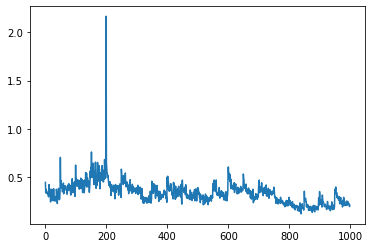

In [33]:
losses = [e['avg_loss'] for e in episodes]
plot_losses(losses)

## Test

In [34]:
make_video(conv_policy_net, env, device=device)

In [35]:
show_video()